In [2]:
#!nvidia-smi

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [4]:
configs = {
    "batch_size" : 512,
    "max_file_count" : 2179,
    "train_file" : 30,
    "validation_file" : 8,
    "test_file" : 8,
    "input_size" :64,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 5,
    "scheduler_min_lr": 3e-6,
    "epoch" : 50,
    "model_name" : "LSTM10",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/219443 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/64218 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/67493 [00:00<?, ?it/s]

In [5]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 8
        self.batch_size = configs["batch_size"]
        self.layer1 = torch.nn.LSTM(1,self.hidden_size,2,batch_first=True,bias=True)
        self.layer2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_size,1,bias=True),
        )

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1,(hn,cn) = self.layer1(input)
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [14]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              928
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─Linear: 2-2                       9
Total params: 937
Trainable params: 937
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              928
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─Linear: 2-2                       9
Total params: 937
Trainable params: 937
Non-trainable params: 0

In [15]:
# L1loss_function = torch.nn.L1Loss()

# def loss_fn(target, input) :
#     penalty = 0.005
#     return torch.mul(torch.mean(torch.lt(torch.mul(target,input),0).type(torch.float32)),penalty) + L1loss_function(target,input)

loss_fn = torch.nn.L1Loss()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [19]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)
        

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        
        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014992749174865328
val loss :  0.01392859010398388


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014988608623497953
val loss :  0.013926943451166154


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014984826581274098
val loss :  0.013927159957587719


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014983235614670215
val loss :  0.013928743071854115


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014977063702976454
val loss :  0.013924911454319953


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014978131936497498
val loss :  0.01392786905169487


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01498043268405458
val loss :  0.013931353323161602


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014974623940293199
val loss :  0.013935125678777695


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014972119870656561
val loss :  0.013926201641559601


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014972185916223816
val loss :  0.013927856653928757


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014969583002362992
val loss :  0.013924740709364414


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014972548294272796
val loss :  0.013927684210240841


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014966190187695705
val loss :  0.01393013521283865


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014967742043103431
val loss :  0.013928402319550514


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496333312939539
val loss :  0.013931812085211277


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963538381575702
val loss :  0.013926464185118675


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014969974880272123
val loss :  0.013921519696712494


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014971128669262769
val loss :  0.013924243345856667


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963395497544068
val loss :  0.01393065018951893


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965905224747746
val loss :  0.01392600804567337


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964863053026878
val loss :  0.013927301809191705


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496592099630387
val loss :  0.013919242568314075


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963724556875146
val loss :  0.013921571329236031


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014966098467654017
val loss :  0.013920642465353012


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014967801963266369
val loss :  0.013924339555203915


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.0149682041749393
val loss :  0.013923361882567405


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496886537044753
val loss :  0.013928080245852471


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964699360028467
val loss :  0.013920136265456677


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965949856423747
val loss :  0.013929339453577995


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964622878426008
val loss :  0.01392600042372942


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496162878949996
val loss :  0.013927139282226563


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964225595364365
val loss :  0.013925355345010758


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496714919753303
val loss :  0.013926599726080895


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965177106749371
val loss :  0.013924749538302422


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965927474218134
val loss :  0.013932373598217964


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014959023854146911
val loss :  0.013923080623149871


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963129600597041
val loss :  0.013926548235118389


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963310782005575
val loss :  0.01393203303217888


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964426815440164
val loss :  0.013930443704128265


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.01496448581080849
val loss :  0.01391936369240284


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014962312950378406
val loss :  0.013922799326479435


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014961519929206121
val loss :  0.013924346446990967


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965633585370171
val loss :  0.013922138474881648


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964365154487368
val loss :  0.013921931631863118


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014962193588769742
val loss :  0.01392682445049286


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014964826757558317
val loss :  0.013927742436528206


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014965066194499487
val loss :  0.013919092133641243


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014963248035235105
val loss :  0.013926071614027024


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014958829283888373
val loss :  0.013923902101814746


  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

train loss :  0.014962741067180428
val loss :  0.013931409858167172


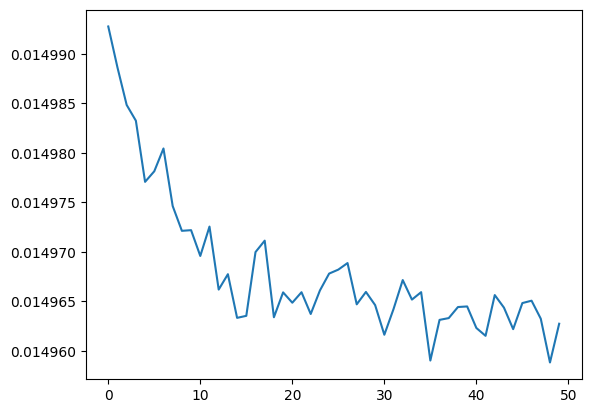

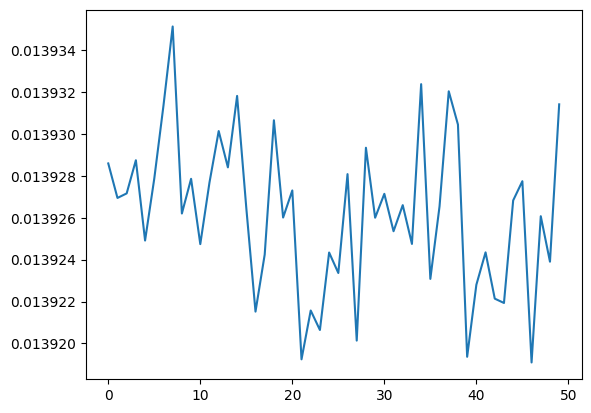

In [20]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [21]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [6]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTM(1, 8, num_layers=2, batch_first=True)
  (layer2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [23]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/132 [00:00<?, ?it/s]

0.014383272744203342


In [15]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [19]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [36]:
def print_trade(best_model, stocks, output_frame) :
    for stock in tqdm(stocks) :
        predict,target = get_log_stock_prediction(best_model, [stock])
        buy_and_hold_profit = trade_test(np.ones(target.shape),target)
        naive_forecast_profit = trade_test(np.concatenate((np.array([0]),(target > 0)))[:-1],target)
        random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
        total_profit = trade_test(predict,target)
        
        new_row = {
            "Name": stock,
            "Buy_and_Hold" : buy_and_hold_profit,
            "Naive_Forecast" : naive_forecast_profit,
            "Random_Profit" : random_profit,
            "Total_Profit" : total_profit
        }
        
        output_frame.loc[len(output_frame.index)] = new_row

In [37]:
testTickers = list(map(str.strip,open("testTickers.txt","r").readlines()))
test_filenames = ["./data/" + x + ".csv" for x in testTickers]
output_frame = pd.DataFrame(columns=["Name","Buy_and_Hold","Naive_Forecast","Random_Profit","Total_Profit"])
print_trade(best_model,test_filenames,output_frame)
output_frame.to_csv("out.csv",index = False)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6073 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4602 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10859 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2774 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7129 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5654 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9710 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6547 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15612 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8196 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12867 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5016 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9969 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6087 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7523 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5772 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7706 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2551 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2932 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9949 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10224 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6509 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6707 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6935 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10994 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10151 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11259 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11047 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[]

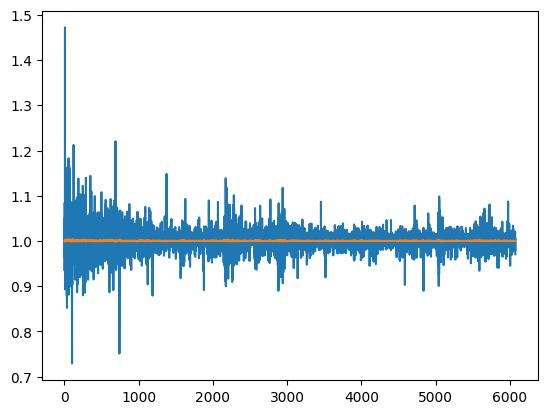

In [12]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [32]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.5089741478676107


In [13]:
plt.plot(learning_rates)
plt.show()

NameError: name 'learning_rates' is not defined